## Importation des packages

In [132]:
#On importe tous les packages nécessaires

from pymatgen.ext.matproj import MPRester
import numpy as np
import scipy.constants as sc
import matplotlib.image as mpimg
from pymatgen.electronic_structure.core import Spin
from pymatgen.electronic_structure.plotter import *
from pymatgen.electronic_structure.plotter import BSPlotter
import matplotlib.pyplot as plt

## Téléchargement de la structure 

In [133]:
with MPRester ("ozHTdwh3TX0utQzQ") as m:
    
    #On crée notre stucture sur base du fichier MP
    structure = m.get_structure_by_material_id("mp-9364")
    

## 1) Détermination de la bande interdite : 

#### On utilise la fonction get_band_gap()

In [134]:
with MPRester ("ozHTdwh3TX0utQzQ") as m:
    band = m.get_bandstructure_by_material_id("mp-9364")
print("Notre Band gap =",band.get_band_gap()['energy'],"[eV]")

Notre Band gap = 2.2754 [eV]


#### Plot pour visualiser : 


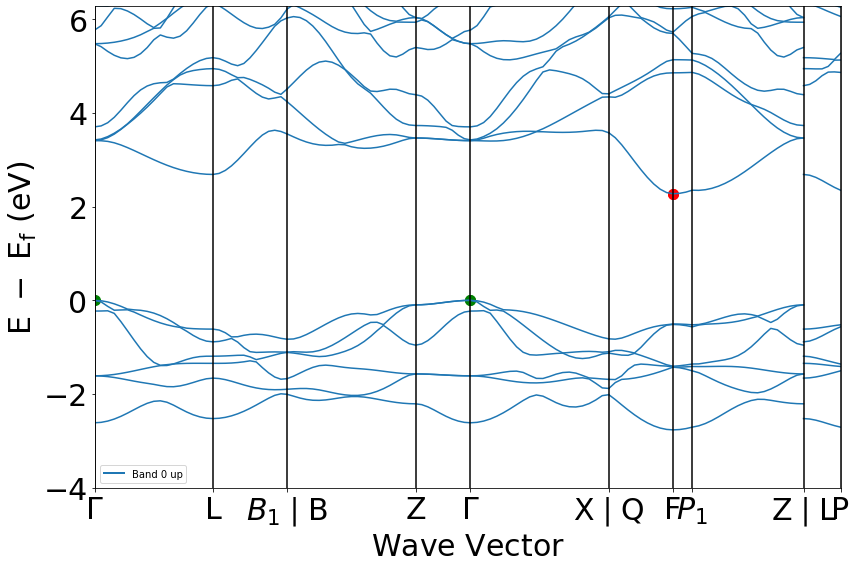

In [135]:
plot = BSPlotter(band) 
plot.get_plot(vbm_cbm_marker=True)
Data = plot.bs_plot_data()

### Analyse du graphe 

On voit que la bande interdite est indirecte, le gap vaut 2.2754 [eV]. 



## 2) Maximum et Minimum de dispersion :

In [136]:
vbm = band.get_vbm()['band_index'] 
print(vbm)
print("On voit que les bandes de valence 14 et 15 contiennent la plus grande énergie")

defaultdict(<class 'list'>, {<Spin.up: 1>: [14, 15]})
On voit que les bandes de valence 14 et 15 contiennent la plus grande énergie


In [137]:
cbm = band.get_cbm()['band_index']
print(cbm)
print("On voit ici que 16ème bande contient l'énergie la plus basse")

defaultdict(<class 'list'>, {<Spin.up: 1>: [16]})
On voit ici que 16ème bande contient l'énergie la plus basse


### On va maintenant rechercher les plus grandes et plus petites valeurs de pentes représentant le maximum et minimum de dispersion.

#### On commence par créer et initialiser toutes les valeurs dont on aura besoin : 

In [138]:
Data = plot.bs_plot_data()
dist = Data.get('ticks').get('distance')
print (dist)
print("On ne garde pas toutes les valeurs des distances à cause des dégénérescences")
distV2 = np.array([dist[0],dist[1],dist[3],dist[4],dist[6],dist[8],dist[9],dist[11],dist[13],dist[14]])
print(distV2)
Energy = Data.get('energy')
BranchVector = Data.get('distances')

[0.0, 0.8797319428986422, 0.8797319428986422, 1.430638263613161, 2.3851737717922314, 2.3851737717922314, 2.7929578453182202, 2.7929578453182202, 3.821131920122274, 4.298399752366688, 4.298399752366688, 4.4408215693778725, 4.4408215693778725, 5.267473523152491, 5.5426339456213505]
On ne garde pas toutes les valeurs des distances à cause des dégénérescences
[0.         0.87973194 1.43063826 2.38517377 2.79295785 3.82113192
 4.29839975 4.44082157 5.26747352 5.54263395]


In [139]:
DiffAbsc = np.zeros(9); DiffOrdCond = np.zeros(9) ; DiffOrdVal = np.zeros(9) ; SlopeCond = np.zeros(9) ;
SlopeVal = np.zeros(9)

for i in range(9):
    DiffAbsc[i] = distV2[i+1] - distV2[i]
    
for i in range(9):
    DiffOrdVal[i] =Energy.get('1')[i][15][-1] - Energy.get('1')[i][15][0]
    DiffOrdCond[i] =Energy.get('1')[i][16][-1] - Energy.get('1')[i][16][0]
    
for i in range (9):
    SlopeCond [i] = DiffOrdCond[i]/DiffAbsc[i]
    SlopeVal[i] = DiffOrdVal[i]/DiffAbsc[i]

MaxSlopeVal = np.max(abs(SlopeVal))
MinSlopeVal = np.min(abs(SlopeVal))
MaxSlopeCond = np.max(abs(SlopeCond))
MinSlopeCond = np.min(abs(SlopeCond))

### On peut donc imprimer nos dispersions maximales et minimales pour chaque bande

print (MaxSlopeVal)
print (MinSlopeVal)
print (MaxSlopeCond)
print (MinSlopeCond)



0.7996700365710857
0.12849154984845373
2.726980349544046
0.09093428086880197


### Bande de valence 

Plus petite pente : 0.12849154984845373

Plus grande pente : 0.7996700365710857

### Bande de conduction 

Plus petite pente : 0.09093428086880197

Plus grande pente : 2.726980349544046

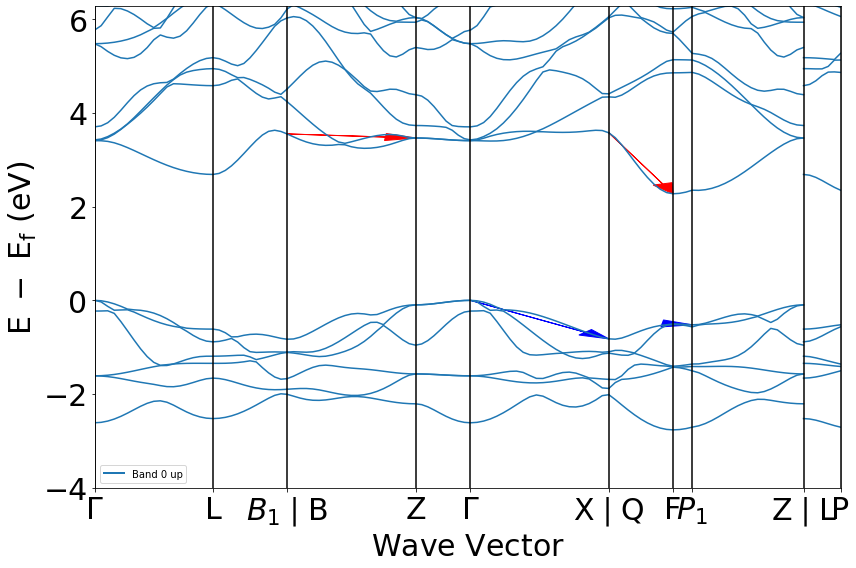

In [140]:
plot.get_plot()
plt.arrow(distV2[4], (Energy.get('1')[4][15])[0], DiffAbsc[4], DiffOrdVal[4], color = 'b', head_width = 0.15,length_includes_head=True)
plt.arrow(distV2[6], (Energy.get('1')[6][15])[0], DiffAbsc[6], DiffOrdVal[6], color = 'b', head_width = 0.15,length_includes_head=True)
plt.arrow(distV2[5], (Energy.get('1')[5][16])[0], DiffAbsc[5], DiffOrdCond[5], color = 'r', head_width = 0.15,length_includes_head=True)
plt.arrow(distV2[2], (Energy.get('1')[2][16])[0], DiffAbsc[2], DiffOrdCond[2], color = 'r', head_width = 0.15,length_includes_head=True)

plt.show()


Ci-dessus, les pentes minimales et maximales pour la bande de conduction <font color='red'> (rouge) <font color='black'>et pour la bande de valence <font color='blue'> (bleu)

## 3) Calcul de la masse effective :


On va maintenant calculer la masse effective au sommet de la dernière bande de valence et à la base de la première bande de conduction. On sait que la masse effective est sous forme tensorielle en toutes généralités, et que ce tenseur est symétrique. Il se présente donc comme une diagonale de 3 éléments. Si on suppose une relation de dispersion parabolique, on peut réduire le tenseur diagonal à un scalaire. On calcule donc la masse effective via la formule qui suit : 

<img src ="masse.jpg" style = "width:200px; height:100px"/>

In [141]:
#### Les abscisses qui nous intéressent ####

Gx = BranchVector[3] 
GXx = BranchVector[4] 
QFx = BranchVector[5] 
FP1x = BranchVector[6] 

### Les ordonnées qui nous intéressent ####

# Pour la bande de valence
G_Ord_Val = Energy.get('1')[3][15] 
GX_Ord_Val = Energy.get('1')[4][15] 

# Pour la bande de conduction
QF_Ord_Cond = Energy.get('1')[5][16] 
FP1_Ord_Cond = Energy.get('1')[6][16] 

On va maintenant faire un polyfit de la parabole et récupérer les coefficients pour les deux bandes, pour pouvoir les utiliser et calculer la masse effective via la formule introduite plus haut. 

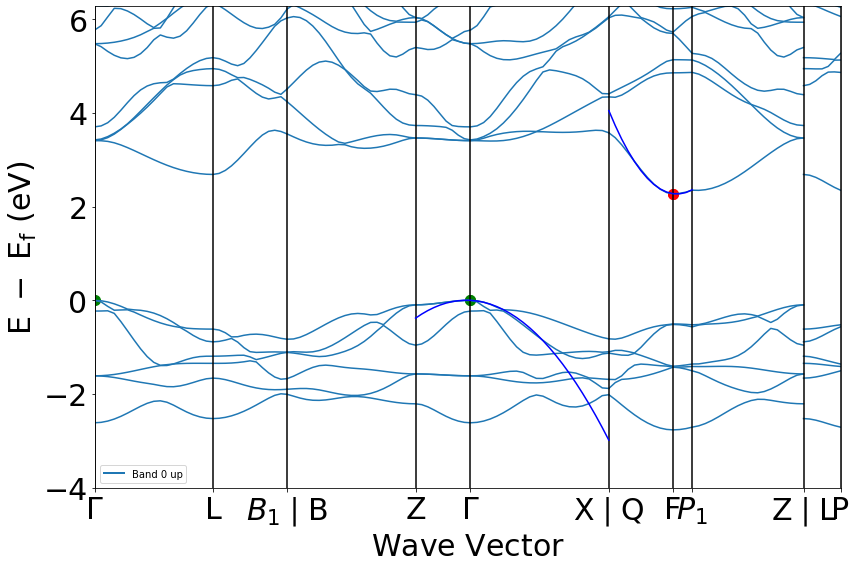

In [142]:
# On va donc faire un polyfit pour trouver la parabole qui épouse le mieux la forme de la 
# dispersion rélle sur notre graphe. On va se donner des points à gauche et à droite des extrémas (connus)


### Les points choisis (4) à gauche et à droite ###
AbscVal = np.append(Gx[-4:],GXx[0:4]) 
AbscCond = np.append(QFx[-4:],FP1x[0:4]) 
OrdVal = np.append(G_Ord_Val[-4:],GX_Ord_Val[0:4]) 
OrdCond = np.append(QF_Ord_Cond[-4:],FP1_Ord_Cond[0:4]) 


### Les coefficients obtenus par polyfit sur chaque bande, placés dans un tableau ###
CoefTabVal= np.polyfit(AbscVal,OrdVal,2) 
CoefTabCond = np.polyfit(AbscCond,OrdCond,2) 


### On donne des tableaux de coordonnées pour tracer les deux paraboles ###
AbsValPlot = np.append(Gx,GXx) 
AbsCondPlot = np.append(QFx,FP1x) 
OrdValPlot = np.append(G_Ord_Val,GX_Ord_Val) 
OrdCondPlot = np.append(QF_Ord_Cond,FP1_Ord_Cond) 


### On fait le plot avec les tableaux ci-dessus ###
plot.get_plot(vbm_cbm_marker=True) 
plt.plot(AbsValPlot,CoefTabVal[0]*AbsValPlot**2+CoefTabVal[1]*AbsValPlot+CoefTabVal[2],color='blue') 
plt.plot(AbsCondPlot,CoefTabCond[0]*AbsCondPlot**2+CoefTabCond[1]*AbsCondPlot+CoefTabCond[2],color='blue') 
plt.show()

In [143]:
print((sc.hbar)*(sc.hbar)/(10**(-20)*sc.e*2*CoefTabVal[0]))
print((sc.hbar)**2/(10**(-20)*sc.e*2*CoefTabCond[0]))

-1.2993362522492145e-30
4.990098947969355e-31


On peut donc conclure avec les valeurs finales des masses effectives. On a simplement à diviser par le <font color = red>double <font color = black> du premier coefficient de la parabole (celui du terme en x^2) car on dérive 2 fois une parabole, tous les autres coefficients disparaissent lors de la dérivation. 
On a divisé notre expression par la valeur de l'Angström au carré et de l'eV pour avoir une masse exprimée en kilogrammes. 

Pour la bande de conduction : masse effective = 4.990098947969355e-31 [kg] (à la base)
    
Pour la bande de valence : masse effective = -1.2993362522492145e-30 [kg] (au sommet) 

